In [24]:
##External
import numpy as np
import pandas as pd
from pprint import pprint
import os
import re
from datasets import Dataset, load_from_disk
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
#import nltk
#from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer, WhitespaceTokenizer
#import textwrap
#nltk.download('punkt')

#Internal
import data_cleaning.data_cleaning as dc

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# 1. Data Preparation
We will start by opening our dataset and formatting it for the training step.
<br>


## Opening the UFRGS Documents dataset
The easiest way to use our data with HuggingFace is to use the datasets library. It allows us to import our own data and it will format it into a Dataset Object that is ready to be used by the NER model.

In the 03_make_dataset notebook we already saved our annotated dataset as a HuggingFace Dataset. Now we need to open it to start prepping it from the training workflow.

In [21]:
ner_dataset = load_from_disk("../data/annotated/ufrgs_documents_13-06-25")
ner_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 676
})

In [9]:
#pprint(ner_dataset['id'][3])
print(ner_dataset['tokens'][5])
print(ner_dataset['ner_tags'][5])

['Autorizar', 'o', 'afastamento', 'do', 'país', 'de', 'RAFAEL', 'ROESLER', ',', 'Professor', 'do', 'Maigstério', 'Superior', ',', 'lotado', 'e', 'em', 'exercício', 'no', 'Departamento', 'de', 'Farmacologia', 'do', 'Instituto', 'de', 'Ciências', 'Básicas', 'da', 'Saúde', ',', 'com', 'a', 'finalidade', 'de', 'participar', 'de', 'reunião', 'na', 'University', 'of', 'Nottingham', '-', 'Inglaterra', ',', 'no', 'período', 'compreendido', 'entre', '02/09/2016', 'e', '10/09/2016', ',', 'com', 'limitado', '.']
[0, 0, 0, 0, 0, 0, 1, 2, 0, 9, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 5, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0]


## Splitting dataset into train and test
We'll split our DataFrame into to lists of lists. One for the input tokens and another for the labels.
After that we'll use the scklearn train_test_split method to get both our train and test data.

In [ ]:
# Split X and y into train and test.
split_dataset = ner_dataset.train_test_split(test_size=0.33, seed=43)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 452
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 224
    })
})


## Visualizing the label distribution in test and train

Number of samples in train set: 452
Amount of each label in the dataset:
8     1854
2     1608
7     1326
10     873
1      653
9      652
4      619
3      297
5      106
6       65
Name: count, dtype: int64
bar graph of labels:


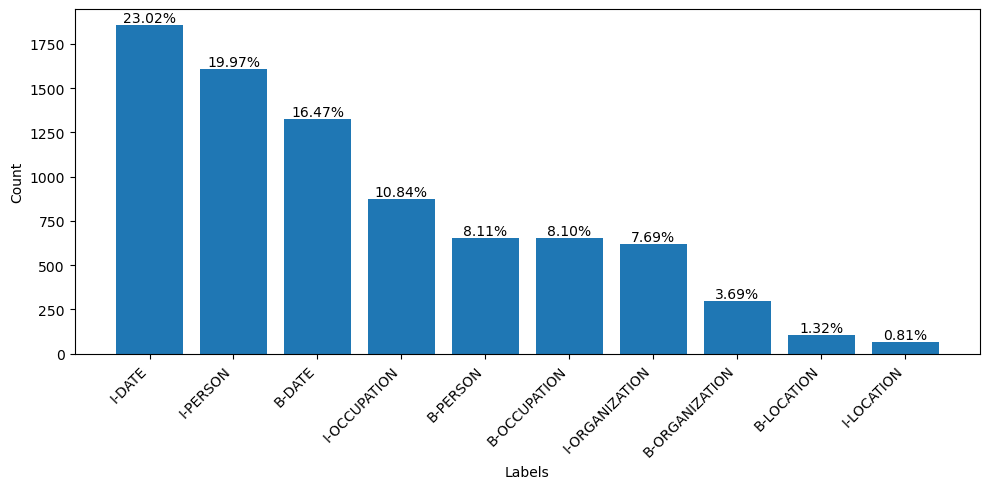

Number of samples in test set: 224
Amount of each label in the dataset:
8     988
2     723
7     619
10    461
4     381
9     330
1     295
3     183
5      47
6      19
Name: count, dtype: int64
bar graph of labels:


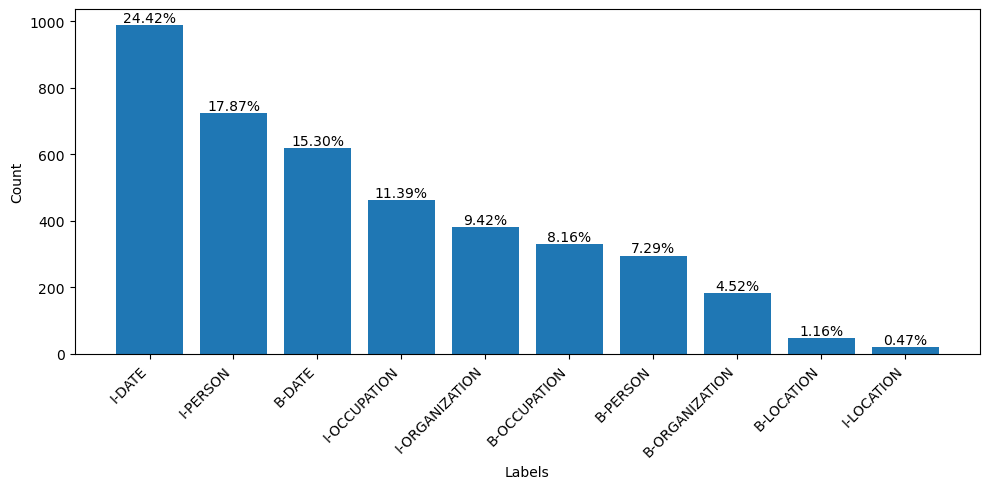

In [ ]:
id_to_label = {
    0: 'O',
    1: 'B-PERSON',
    2: 'I-PERSON',
    3: 'B-ORGANIZATION',
    4: 'I-ORGANIZATION',
    5: 'B-LOCATION',
    6: 'I-LOCATION',
    7: 'B-DATE',
    8: 'I-DATE',
    9: 'B-OCCUPATION',
    10: 'I-OCCUPATION'
}

for split in ['train', 'test']:
    print(f"Number of samples in {split} set: {len(split_dataset[split])}")
    label_series = pd.Series(split_dataset[split]['ner_tags']).explode()
    label_series = label_series[label_series != 0]  # Remove padding labels
    print("Amount of each label in the dataset:")
    print(label_series.value_counts())
    print("bar graph of labels:")
    plt.figure(figsize=(10, 5))
    
    # Convert numeric labels to string labels for plotting
    label_counts = label_series[label_series != 0].value_counts()
    label_names = [id_to_label[label_id] for label_id in label_counts.index]
    
    # Make a bar graph of the labels
    plt.bar(label_names, label_counts.values)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    
    # Add percentage on top of each bar
    for i, v in enumerate(label_series[label_series != "O"].value_counts()):
        plt.text(i, v + 0.5, f"{v/label_series[label_series != "O"].size*100:.2f}%", ha='center', va='bottom')
        
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

## Tokenization: Sub-word convertion
We create a tokenizer to convert our inputs into sub-word ids. We need to use a tokenizer that is compatible with the model we'll use.
HuggingFace makes that easy through the AutoTokenizer, which allows us to specify which model will be used and it already makes sure that our tokenizer will work with it.


In [25]:
checkpoint = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Testing the sub-word tokenizer

In [62]:
# We use one of the samples to test the tokenizer
testenizer = tokenizer(split_dataset['train'][8]['tokens'], is_split_into_words=True)
testenizer

{'input_ids': [101, 476, 4623, 22282, 146, 8750, 117, 123, 1018, 125, 1906, 125, 1592, 125, 6437, 117, 125, 18471, 18532, 5234, 213, 18469, 5650, 448, 7073, 22304, 22346, 22327, 5054, 117, 12600, 14188, 200, 5234, 8214, 100, 19148, 22334, 21509, 7997, 117, 3045, 175, 171, 2466, 125, 12118, 183, 122, 8752, 7839, 8849, 117, 180, 5985, 125, 5027, 124, 5706, 180, 11635, 22301, 22309, 221, 146, 530, 428, 125, 12995, 9394, 180, 2296, 1017, 21245, 125, 5027, 124, 5706, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [65]:
#The tokenizer return looks like a dictionary but it is actually an object called BatchEncoding
print(type(testenizer), '\n')

#print each key in the tokenizer object
print("")
for key in testenizer.keys():
    print(f"{key}: {testenizer[key]}")
print('\n')

#The object has a tokens method that returns the original tokens before transforming them into integers
# The word_ids methods returns a list with the ID that maps each sub-word to the original word it was tokenized from.
for item1, item2 in zip(testenizer.word_ids(), testenizer.tokens()):
    print(f"{item1} {item2}")

<class 'transformers.tokenization_utils_base.BatchEncoding'> 


input_ids: [101, 476, 4623, 22282, 146, 8750, 117, 123, 1018, 125, 1906, 125, 1592, 125, 6437, 117, 125, 18471, 18532, 5234, 213, 18469, 5650, 448, 7073, 22304, 22346, 22327, 5054, 117, 12600, 14188, 200, 5234, 8214, 100, 19148, 22334, 21509, 7997, 117, 3045, 175, 171, 2466, 125, 12118, 183, 122, 8752, 7839, 8849, 117, 180, 5985, 125, 5027, 124, 5706, 180, 11635, 22301, 22309, 221, 146, 530, 428, 125, 12995, 9394, 180, 2296, 1017, 21245, 125, 5027, 124, 5706, 119, 102]
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Target Alignment
Now that our input is composed of sub-words, we need to make sure that we have one target per sub-word. To do this we will use the align_targets function and map targets from each word to its sub-words.

In [ ]:
#Define relationship between B and I tags
begin2inside = {
    1: 2,   # B-PERSON -> I-PERSON
    3: 4,   # B-ORGANIZATION -> I-ORGANIZATION  
    5: 6,   # B-LOCATION -> I-LOCATION
    7: 8,   # B-DATE -> I-DATE
    9: 10   # B-OCCUPATION -> I-OCCUPATION 
}

# Function that aligns the labels to be correctly associated with each sub-word.
def align_targets(labels, word_ids):
    aligned_labels = []
    previous_word = None

    for word in word_ids:
        if word is None:
            # Tokens like [CLS] and [SEP]
            label = -100 #This value is used by Hugging Face to ignore the tokens during training
        elif word != previous_word:
            # New word in the list
            label = labels[word]
        else:
            #Repeated word (Would be the next sub-word)
            if labels[word] in begin2inside:
                #Change B- to I-
                label = begin2inside[labels[word]]
            else:
                # Sub-word of a word classified as "O" gets the same label "O"
                label = labels[word]

        aligned_labels.append(label)
        previous_word = word #update last word
 
    return aligned_labels

In [542]:
## Label-Token Alignment Test
idx = 6
test_data = tokenizer(ufrgs_data['train'][idx]['inputs'], is_split_into_words=True)
print("Tokenized Data:", test_data)
print("Word Tokens:", ufrgs_data['train'][idx]['inputs'])
test_labels = ufrgs_data['train'][idx]['targets']
print("Word Labels:", test_labels)
print("Word IDs:", test_data.word_ids())
aligned_targets = align_targets(test_labels, test_data.word_ids())
print("Sub-Word Labels:", aligned_targets)
print("Sub-Word Tokens:", test_data.tokens())

Tokenized Data: {'input_ids': [101, 205, 120, 205, 212, 8718, 5118, 21748, 22301, 100, 8103, 5752, 125, 16720, 120, 16899, 120, 5096, 177, 5427, 9617, 118, 257, 18469, 15349, 5650, 250, 22301, 7281, 9846, 5054, 22308, 6392, 11836, 22309, 263, 12002, 5054, 9369, 15040, 257, 15749, 278, 5650, 22320, 7545, 15040, 200, 18199, 117, 202, 1700, 125, 675, 20215, 117, 9319, 146, 16620, 229, 14120, 322, 100, 16444, 8510, 117, 125, 2939, 125, 1544, 125, 4284, 257, 3341, 7918, 22339, 22309, 3928, 15802, 6939, 150, 8346, 117, 240, 7887, 125, 4576, 117, 202, 12106, 157, 1014, 1582, 117, 320, 8922, 299, 6072, 22309, 17715, 22322, 22055, 22308, 278, 18178, 3341, 15040, 22308, 16288, 22333, 6072, 117, 12600, 14188, 200, 5234, 8214, 149, 22359, 22222, 4649, 22330, 22330, 117, 1340, 487, 122, 173, 8750, 202, 5985, 125, 8153, 1262, 171, 2900, 125, 9682, 122, 5503, 7023, 138, 117, 180, 3383, 250, 125, 8922, 8688, 243, 117, 2270, 19148, 117, 221, 123, 3383, 250, 125, 8922, 8688, 243, 117, 2270, 16720, 117, 

In [543]:
aligned_labels = [target_labels[t] if t>=0 else None for t in aligned_targets]
for x, y in zip(test_data.tokens(), aligned_labels):
    print(f"{x}\t{y}")
    

[CLS]	None
1	O
/	O
1	O
P	O
##OR	O
##TA	O
##RI	O
##A	O
[UNK]	O
38	O
##12	O
de	O
04	O
/	O
05	O
/	O
2017	O
A	O
VI	O
##CE	O
-	O
R	O
##EI	O
##TO	O
##RA	O
D	O
##A	O
UN	B-ORGANIZATION
##IV	I-ORGANIZATION
##ER	I-ORGANIZATION
##S	I-ORGANIZATION
##ID	I-ORGANIZATION
##AD	I-ORGANIZATION
##E	I-ORGANIZATION
F	I-ORGANIZATION
##ED	I-ORGANIZATION
##ER	I-ORGANIZATION
##AL	I-ORGANIZATION
DO	I-ORGANIZATION
R	I-ORGANIZATION
##IO	I-ORGANIZATION
G	I-ORGANIZATION
##RA	I-ORGANIZATION
##N	I-ORGANIZATION
##DE	I-ORGANIZATION
DO	I-ORGANIZATION
S	I-ORGANIZATION
##UL	I-ORGANIZATION
,	O
no	O
uso	O
de	O
suas	O
atribuições	O
,	O
considerando	O
o	O
disposto	O
na	O
Porta	O
##ria	O
[UNK]	O
76	O
##24	O
,	O
de	O
29	O
de	O
setembro	O
de	O
2016	O
R	O
##ES	O
##OL	O
##V	O
##E	O
Conc	O
##eder	O
progress	O
##ão	O
funcional	O
,	O
por	O
avaliação	O
de	O
desempenho	O
,	O
no	O
Quad	O
##ro	O
desta	O
Universidade	O
,	O
ao	O
Professor	B-MISCELLANEOUS
J	B-PERSON
##OS	I-PERSON
##E	I-PERSON
CA	I-PERSON
##R	I-PERSON
##LO	I-PERSON
##S	I-PERS

### Tokenize inputs
We take the sub-word inputs and labels and pass it to the 'tokenize_fn' function to generate the tokens we'll feed to the model.

In [544]:
# Function to tokenize both inputs and targets
def tokenize_fn(batch):
    # Tokenize the input sequence first
    tokenized_inputs = tokenizer(batch['inputs'], truncation=True, is_split_into_words=True)
    labels_batch = batch['targets'] # The original targets word-by-word
    aligned_labels_batch = [] # The aligned targets sub-word by sub-word
    # Loop through each label sequence in the batch
    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i) # Get word IDs for the sequence
        aligned_labels_batch.append(align_targets(labels, word_ids)) # Align sequence labels
    
    # Save final aligned labels in a column called 'labels' which is the required name for the hugging face models
    tokenized_inputs['labels'] = aligned_labels_batch
    
    return tokenized_inputs

In [545]:
ufrgs_data['train']

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 38
})

In [546]:
# Use the datasets method 'map' to apply the tokenize function to the train and test datasets.
# We'll use the batched parameter to improve the eficiency of the tokenization.
tokenized_datasets = ufrgs_data.map(
	tokenize_fn,
	batched=True,
	remove_columns=ufrgs_data["train"].column_names
)

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/19 [00:00<?, ? examples/s]

In [547]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 38
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 19
    })
})

### Test the DataCollator
There are several required steps before passing the text into the model: padding, truncate, converting to tensors, etc. When we use the tokenizer method we are not doing most of these steps because the ‘data collator’ in the trainer is taking care of it implicitly when we train the model.

The Data Collator is built into the trainer and is defined as such:

> • **data_collator** (`DataCollator`, *optional*) — The function to use to form a batch from a list of elements of `train_dataset` or `eval_dataset`. Will default to **[default_data_collator()](https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/data_collator#transformers.default_data_collator)** if no `tokenizer` is provided, an instance of **[DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding)** otherwise.
> 

#### For Token Classification

The Trainer object in Hugging Face is not capable of recognizing which task we are trying to execute and therefore is not able to automatically select the correct Data Collator for us. Since the default DataCollatorWithPadding does not support tasks of the token classification type, we’ll need to manually define the one we want by importing the token classification data collator.

In [548]:
from transformers import DataCollatorForTokenClassification

In [549]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

In [550]:
# Test the data collator. It should return both inputs as tensor of the same size (including the padding).
collator_testset = [tokenized_datasets["train"][i] for i in range(2)]
batch = data_collator(collator_testset)
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    3,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    7,    8,    8,    8,    8,
            8,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            1,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            0,    0,    0,  

### Metrics for validation
Computing metrics isn’t as straight forward when we deal with multiple targets per sample(sentence). Usually when calculating accuracy with a single target we can do #correct_samples/#total_samples. This is not possible when each sample has several targets.
One solution would be flattening all predictions to calculate #correct_targets/#total_targets.
#### Seqeval
This library is the standard method to calculate metrics in hugging face as its sole purpose is to compute metrics for NLP tasks with sequence targets.\
https://huggingface.co/spaces/evaluate-metric/seqeval

In [551]:
from datasets import load_metric
metric = load_metric("seqeval")

In [552]:
# Seqeval will not work with a single input single label task. It will only be usable in tasks that require mulitple labels for multiple inputs
# Single input single label example:
#metric.compute(predictions=[0, 0, 0], references=[0, 0, 1])

In [553]:
# Multilple inputs multiple labels example:
metric.compute(
    predictions=[[0, 0, 0], [1, 0, 1]], 
    references=[[0, 0, 1], [1, 0, 1]])

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\art

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.8333333333333334}

In [554]:
# Seqeval supports sequence labeling evalutation with the IOB formats. So to get rid of the warning and correctly compute the metrics we need to follow this formatting standard.
metric.compute(
    predictions=[['O', 'I-ORG', 'B-ORG', 'B-ORG', 'B-LOC'], ['B-MISC', 'O', 'B-PER', 'I-PER', "I-MISC"]], 
    references=[['O', 'B-LOC', 'B-ORG', 'I-ORG', 'I-ORG'], ['B-MISC', 'I-MISC', 'B-PER', 'I-PER', 'O']])

{'LOC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'MISC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 0.14285714285714285,
 'overall_recall': 0.25,
 'overall_f1': 0.18181818181818182,
 'overall_accuracy': 0.5}

In [555]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    preds = np.argmax(logits, axis=-1)

    # remove -100, convert the label ids to label names
    str_labels = [[target_labels[t] for t in label if t != -100] for label in labels]

    # do the same for predictions whenever true label is -100
    str_preds = [[target_labels[p] for p, t in zip(pred, targ) if t != -100] for pred, targ in zip(preds, labels)]

    the_metrics = metric.compute(predictions=str_preds, references=str_labels)
    return {
        'precision': the_metrics['overall_precision'],
        'recall': the_metrics['overall_recall'],
        'f1': the_metrics['overall_f1'],
        'accuracy': the_metrics['overall_accuracy']
        }

In [556]:
id2label = {k: v for k, v in enumerate(target_labels)} #Get label IDs
label2id = {v: k for k, v in id2label.items()} #Get label names from IDs
id2label

{0: 'O',
 1: 'B-PERSON',
 2: 'I-PERSON',
 3: 'B-ORGANIZATION',
 4: 'I-ORGANIZATION',
 5: 'B-LOCATION',
 6: 'I-LOCATION',
 7: 'B-MISCELLANEOUS',
 8: 'I-MISCELLANEOUS'}

#### Load the pre-trained model

We use the AutoModelForTokenClassification.from_pretrained method to load the BERT model from huggingface.\
The model loades will be the one defined by 'checkpoint'.\
We pass the id2label and label2id parameters for the model to understand the targets we are using for the prediction and training.

In [557]:
from transformers import AutoModelForTokenClassification

In [558]:
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id
)

loading configuration file config.json from cache at C:\Users\arthu/.cache\huggingface\hub\models--neuralmind--bert-base-portuguese-cased\snapshots\94d69c95f98f7d5b2a8700c420230ae10def0baa\config.json
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PERSON",
    "2": "I-PERSON",
    "3": "B-ORGANIZATION",
    "4": "I-ORGANIZATION",
    "5": "B-LOCATION",
    "6": "I-LOCATION",
    "7": "B-MISCELLANEOUS",
    "8": "I-MISCELLANEOUS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOCATION": 5,
    "B-MISCELLANEOUS": 7,
    "B-ORGANIZATION": 3,
    "B-PERSON": 1,
    "I-LOCATION": 6,
    "I-MISCELLANEOUS": 8,
    "I-ORGANIZATION": 4,
    "I-PERSON": 2,
    

#### Create the Training Arguments
The training arguments define several parameters of how the training of the model will happen. Some argument define where the outputs will be save, how often during training we want to compute metric, how many epochs we will use for training, define the learning rate and many others. There are a several arguments which can all be found in the documentation of the function:

[https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments)

The trainer uses AdamW for the backpropagation optimization. We can use a custom one if necessary.

In [559]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "bert-base-portuguese-cased-ner-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


#### Trainer

The trainer object is what we’ll use to run the training process. The arguments are fairly simple:

- The pre-trained model we will use
- The training arguments
- The train dataset (already tokenized)
- The validation dataset
- The data collator
- The metrics we will use for validation
- The tokenizer

The training is done by calling the train method as trainer.train()

In [560]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [561]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [562]:
print(trainer.args.device)
print_gpu_utilization()
!nvidia-smi

cuda:0
GPU memory occupied: 8076 MB.
Mon Apr  3 04:31:11 2023       

In [563]:
result = trainer.train()
print_summary(result)

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25
  Number of trainable parameters = 108339465



+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P5    14W / 180W |   7957MiB /  8192MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--------------------------------------

  0%|          | 0/25 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 19
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-base-portuguese-cased-ner-finetuned\checkpoint-5
Configuration saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-5\config.json


{'eval_loss': 1.4058964252471924, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.7182601880877743, 'eval_runtime': 0.6931, 'eval_samples_per_second': 27.411, 'eval_steps_per_second': 4.328, 'epoch': 1.0}


Model weights saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-5\pytorch_model.bin
tokenizer config file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-5\tokenizer_config.json
Special tokens file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-5\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-base-portuguese-cased-ner-finetuned\checkpoint-10
Configuration saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-10\config.json


{'eval_loss': 0.9357545971870422, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.7394200626959248, 'eval_runtime': 0.6373, 'eval_samples_per_second': 29.812, 'eval_steps_per_second': 4.707, 'epoch': 2.0}


Model weights saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-10\pytorch_model.bin
tokenizer config file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-10\tokenizer_config.json
Special tokens file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-10\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-base-portuguese-cased-ner-finetuned\checkpoint-15
Configuration saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-15\config.json


{'eval_loss': 0.7065246105194092, 'eval_precision': 0.1, 'eval_recall': 0.04597701149425287, 'eval_f1': 0.06299212598425197, 'eval_accuracy': 0.832680250783699, 'eval_runtime': 0.7271, 'eval_samples_per_second': 26.133, 'eval_steps_per_second': 4.126, 'epoch': 3.0}


Model weights saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-15\pytorch_model.bin
tokenizer config file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-15\tokenizer_config.json
Special tokens file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-15\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-base-portuguese-cased-ner-finetuned\checkpoint-20


{'eval_loss': 0.5992717146873474, 'eval_precision': 0.8285714285714286, 'eval_recall': 0.3333333333333333, 'eval_f1': 0.47540983606557374, 'eval_accuracy': 0.850705329153605, 'eval_runtime': 0.6647, 'eval_samples_per_second': 28.584, 'eval_steps_per_second': 4.513, 'epoch': 4.0}


Configuration saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-20\config.json
Model weights saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-20\pytorch_model.bin
tokenizer config file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-20\tokenizer_config.json
Special tokens file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-20\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\arthu\anaconda3\envs\NLP22\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-base-portuguese-cased-ner-finetuned\checkpoint-25
Configuration saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-25\config.json


{'eval_loss': 0.5647721290588379, 'eval_precision': 0.7111111111111111, 'eval_recall': 0.367816091954023, 'eval_f1': 0.48484848484848486, 'eval_accuracy': 0.8557993730407524, 'eval_runtime': 0.6702, 'eval_samples_per_second': 28.351, 'eval_steps_per_second': 4.476, 'epoch': 5.0}


Model weights saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-25\pytorch_model.bin
tokenizer config file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-25\tokenizer_config.json
Special tokens file saved in bert-base-portuguese-cased-ner-finetuned\checkpoint-25\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 131.4418, 'train_samples_per_second': 1.446, 'train_steps_per_second': 0.19, 'train_loss': 1.0373165130615234, 'epoch': 5.0}
Time: 131.44
Samples/second: 1.45
GPU memory occupied: 8079 MB.


In [564]:
print_gpu_utilization()

GPU memory occupied: 8082 MB.


In [565]:
type(trainer.train_dataset)

datasets.arrow_dataset.Dataset

In [566]:
trainer.save_model('auto_tagger')

Saving model checkpoint to auto_tagger
Configuration saved in auto_tagger\config.json
Model weights saved in auto_tagger\pytorch_model.bin
tokenizer config file saved in auto_tagger\tokenizer_config.json
Special tokens file saved in auto_tagger\special_tokens_map.json


In [567]:

from transformers import pipeline

ner = pipeline(
    "token-classification",
    model='auto_tagger',
    aggregation_strategy="average",
    ignore_labels=[""],
    device=0
)

loading configuration file auto_tagger\config.json
Model config BertConfig {
  "_name_or_path": "auto_tagger",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PERSON",
    "2": "I-PERSON",
    "3": "B-ORGANIZATION",
    "4": "I-ORGANIZATION",
    "5": "B-LOCATION",
    "6": "I-LOCATION",
    "7": "B-MISCELLANEOUS",
    "8": "I-MISCELLANEOUS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOCATION": 5,
    "B-MISCELLANEOUS": 7,
    "B-ORGANIZATION": 3,
    "B-PERSON": 1,
    "I-LOCATION": 6,
    "I-MISCELLANEOUS": 8,
    "I-ORGANIZATION": 4,
    "I-PERSON": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_pa

In [583]:
test_sample = """Documento gerado sob autenticação Nº NIK.843.557.VM6, disponível no endereço http://www.ufrgs.br/autenticacao
1/1
PORTARIA Nº             1181                  de  18/02/2016
O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no
uso de suas atribuições que lhe foram conferidas pela Portaria nº.5469, de 04 de outubro de 2012, do
Magnífico Reitor, e conforme o Laudo Médico n°37564,
RESOLVE:
Designar, temporariamente, nos termos da Lei nº. 8.112, de 11 de dezembro de 1990, com redação
dada  pela  Lei  nº.9.527,  de  10  de  dezembro  de  1997,  a  ocupante  do  cargo  de  ASSISTENTE  EM
ADMINISTRAÇÃO, do Quadro de Pessoal desta Universidade, DENISE SCHROEDER (Siape: 0358763 ),  para
substituir   MARILDA SANTOS DA ROCHA (Siape: 1044125 ), Secretário do Depto de Plantas Forrageiras e
Agrometeorologia da Faculdade de Agronomia, Código FG-7, em seu afastamento por motivo de Laudo
Médico do titular da Função, no período de 03/02/2016 a 10/02/2016, com o decorrente pagamento das
vantagens por 8 dias.
MAURÍCIO VIÉGAS DA SILVA
Pró-Reitor de Gestão de Pessoas""" 
clean_sample = data_processing.clear_text(test_sample)
print(clean_sample)
token_sample = tokenizer(clean_sample)
print(token_sample.tokens())

Documento gerado sob autenticação Nº NIK.843.557.VM6, disponível no endereço http://www.ufrgs.br/autenticacao 1/1 PORTARIA Nº 1181 de 18/02/2016 O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no uso de suas atribuições que lhe foram conferidas pela Portaria nº 5469, de 04 de outubro de 2012, do Magnífico Reitor, e conforme o Laudo Médico n°37564, RESOLVE: Designar, temporariamente, nos termos da Lei nº 8.112, de 11 de dezembro de 1990, com redação dada pela Lei nº 9.527, de 10 de dezembro de 1997, a ocupante do cargo de ASSISTENTE EM ADMINISTRAÇÃO, do Quadro de Pessoal desta Universidade, DENISE SCHROEDER (Siape: 0358763 ), para substituir MARILDA SANTOS DA ROCHA (Siape: 1044125 ), Secretário do Depto de Plantas Forrageiras e Agrometeorologia da Faculdade de Agronomia, Código FG-7, em seu afastamento por motivo de Laudo Médico do titular da Função, no período de 03/02/2016 a 10/02/2016, com o decorrente pagamento das vantagens por 8 dias. MAURÍCIO VIÉGA

In [584]:
type(ner)

transformers.pipelines.token_classification.TokenClassificationPipeline

In [606]:
results = ner(clean_sample)
results

[{'entity_group': 'O',
  'score': 0.82746357,
  'word': 'Documento gerado sob autenticação Nº NIK. 843. 557. VM6, disponível no endereço http : / / www. ufrgs. br / autenticacao 1 / 1 PORTARIA Nº 1181 de 18 / 02 / 2016 O PRÓ - REITOR DE',
  'start': 0,
  'end': 160},
 {'entity_group': 'MISCELLANEOUS',
  'score': 0.3277286,
  'word': 'GESTÃO',
  'start': 161,
  'end': 167},
 {'entity_group': 'O',
  'score': 0.4662776,
  'word': 'DE PESSOAS DA',
  'start': 168,
  'end': 181},
 {'entity_group': 'ORGANIZATION',
  'score': 0.669568,
  'word': 'UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL',
  'start': 182,
  'end': 223},
 {'entity_group': 'O',
  'score': 0.8813147,
  'word': ', no uso de suas atribuições que lhe foram conferidas pela Portaria nº 5469, de 04 de outubro de 2012, do Magnífico Reitor, e conforme o Laudo Médico n°37564, RESOLVE : Designar, temporariamente, nos termos da Lei nº 8. 112, de 11 de dezembro de 1990, com redação dada pela Lei nº 9. 527, de 10 de dezembro de 1997, a ocupan

In [626]:
def reformat_sentence(original_sentence, tagged_results):
    og_sentence_pos = 0
    tagged_sentence_pos = 0
    formatted_results = []
    for entity in tagged_results:
        formatted_entity = ""
        #print(entity['word'])
        for index_char, char in enumerate(entity['word']):
            #print(char, original_sentence[og_sentence_pos])
            if char == original_sentence[og_sentence_pos]:
                og_sentence_pos += 1
                formatted_entity = formatted_entity + char
            else:
                #print("Bad char:", char)
                # #Look ahead and see if next char is equal to original
                if entity['word'][index_char+1] == original_sentence[og_sentence_pos]:
                    #print("Found char in next pos")
                    pass
                # Else add the character to the formatted entity
                else:
                    og_sentence_pos += 2
                    formatted_entity = formatted_entity + char

        #print("Formatted:", formatted_entity)
        formatted_result = entity.copy()
        formatted_result['word'] = formatted_entity
        formatted_results.append(formatted_result)
    return formatted_results

In [622]:
reformatted_sentence = reformat_sentence(clean_sample, results)
sentence_for_relabelling = ""
for entity in reformatted_sentence:
    sentence_for_relabelling = sentence_for_relabelling + entity['word'] + ' '
sentence_for_relabelling = re.sub(' ,', ',', sentence_for_relabelling)

In [623]:
print(sentence_for_relabelling)
print(clean_sample)

Documento gerado sob autenticação Nº NIK.843.557.VM6, disponível no endereço http://www.ufrgs.br/autenticacao 1/1 PORTARIA Nº 1181 de 18/02/2016 O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no uso de suas atribuições que lhe foram conferidas pela Portaria nº 5469, de 04 de outubro de 2012, do Magnífico Reitor, e conforme o Laudo Médico n°37564, RESOLVE: Designar, temporariamente, nos termos da Lei nº 8.112, de 11 de dezembro de 1990, com redação dada pela Lei nº 9.527, de 10 de dezembro de 1997, a ocupante do cargo de ASSISTENTE EM ADMINISTRAÇÃO, do Quadro de Pessoal desta Universidade, DENISE SCHROEDER  Siape: 0358763 ), para substituir MARILDA SANTOS DA ROCHA  Siape: 1044125 ), Secretário do Depto de Plantas Forrageiras e Agrometeorologia da Faculdade de Agronomia, Código FG-7, em seu afastamento por motivo de Laudo Médico do titular da Função, no período de 03/02/2016 a 10/02/2016, com o decorrente pagamento das vantagens por 8 dias. MAURÍCIO VIÉGA

In [ ]:
def join_sentence(tagged_sentence):
    list_of_words = []
    for token in tokens:
        